In [10]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [11]:
# # Check if a GPU is available
# gpu_available = tf.config.list_physical_devices('GPU')

# if gpu_available:
#     # Set TensorFlow to use GPU
#     tf.config.experimental.set_memory_growth(gpu_available[0], True)
#     print("GPU is available and configured.")
# else:
#     print("GPU is not available.")

In [12]:
# from google.colab import files
# files.upload()

In [13]:
# !rm -r ~/.kaggle
# !mkdir ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [14]:
# !kaggle datasets download -d dimasirfan/plants-disease-dataset-subset -p "/content/data"

In [15]:
# local_zip = '/content/data/plants-disease-dataset-subset.zip'
# zip_ref   = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

# Cauliflower Model

In [16]:
base_path = "data/Plant Disease/Plants Disease Dataset Subset" #Local Notebook
source_path = os.path.join(base_path, "Cauliflower")
train_path = os.path.join(source_path, "train")
valid_path = os.path.join(source_path, "valid")

In [17]:
image_size = (224, 224)

In [18]:
base_model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False, 
    weights='imagenet', 
    input_shape=(image_size[0], image_size[1], 3),
    pooling="avg"
)

In [19]:
# Preprocess the input images and apply augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    channel_shift_range=0.2,
    brightness_range=(0.5, 2),
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [29]:
# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=4,
    class_mode='categorical',
    shuffle = True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=2,
    class_mode='categorical',
    shuffle = False
)

Found 171 images belonging to 10 classes.
Found 45 images belonging to 10 classes.


In [32]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, SGD

for layer in base_model.layers:
    layer.trainable = False

with tf.device("GPU"):
    model = Sequential()
    model.add(base_model)
    model.add(Dense(156, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

# Compile the model
learning_rate = 0.01
optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 156)               159900    
                                                                 
 dropout_3 (Dropout)         (None, 156)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1570      
                                                                 
Total params: 3,390,334
Trainable params: 161,470
Non-trainable params: 3,228,864
_________________________________________________________________


In [33]:
checkpoint_callback = ModelCheckpoint('cauli_model_weights.h5', save_best_only=True, save_weights_only=True)
early_stopping_callback = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_accuracy')

epoch = 50
with tf.device('GPU'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epoch,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint_callback, 
                #    early_stopping_callback, 
                   reduce_lr_callback]
    )

Epoch 1/50
43/43 [==============================] - 10s 184ms/step - loss: 2.4164 - accuracy: 0.1813 - val_loss: 1.9812 - val_accuracy: 0.2667 - lr: 0.0100
Epoch 2/50
43/43 [==============================] - 7s 155ms/step - loss: 1.8364 - accuracy: 0.3333 - val_loss: 1.6609 - val_accuracy: 0.5111 - lr: 0.0100
Epoch 3/50
43/43 [==============================] - 7s 155ms/step - loss: 1.5101 - accuracy: 0.4912 - val_loss: 1.7842 - val_accuracy: 0.4444 - lr: 0.0100
Epoch 4/50
43/43 [==============================] - 7s 151ms/step - loss: 1.2145 - accuracy: 0.5731 - val_loss: 1.7115 - val_accuracy: 0.5333 - lr: 0.0100
Epoch 5/50
43/43 [==============================] - 6s 150ms/step - loss: 1.1774 - accuracy: 0.6082 - val_loss: 1.6902 - val_accuracy: 0.5111 - lr: 0.0100
Epoch 6/50
43/43 [==============================] - 7s 152ms/step - loss: 1.1196 - accuracy: 0.6316 - val_loss: 1.6471 - val_accuracy: 0.4667 - lr: 0.0100
Epoch 7/50
43/43 [==============================] - 7s 161ms/step - l

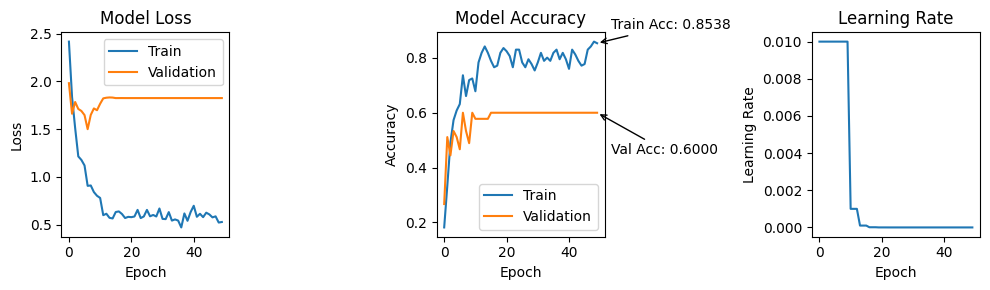

In [35]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(['Train', 'Validation'], loc='upper right')

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Train', 'Validation'], loc='lower right')

axes[2].plot(history.history['lr'])
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')

# Print the final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
axes[1].annotate(f'Train Acc: {final_train_accuracy:.4f}', xy=(len(history.history['accuracy']) - 1, final_train_accuracy), xytext=(10, 10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))
axes[1].annotate(f'Val Acc: {final_val_accuracy:.4f}', xy=(len(history.history['val_accuracy']) - 1, final_val_accuracy), xytext=(10, -30),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()


In [36]:
export_dir = 'saved_model/cauli/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/cauli/1\assets


INFO:tensorflow:Assets written to: saved_model/cauli/1\assets


In [37]:
# mode = "Speed" 

# if mode == 'Storage':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
# elif mode == 'Speed':
#     optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
# else:
#     optimization = tf.lite.Optimize.DEFAULT

In [38]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [39]:
import pathlib
tflite_model_file = pathlib.Path('./assets/cauli_disease.tflite')
tflite_model_file.write_bytes(tflite_model)

3547464